## Timeline

### 1. Import library
### 2. Load Data
### 3. EDA
### 4. Sentiment Analysis
### 5. Data Prerpocessing
### 6. Sentiment Graphing

### 1. Import library

In [13]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
# 모듈 설치
# !pip install konlpy
# !pip install transformers
# !pip install tensorflow_addons
# !pip install xformers
# 데이터 처리 모듈
import pandas as pd
import numpy as np
import copy
import re
import math
import json
import requests
import urllib.request
from tqdm import tqdm
import datetime
import time
import os
import random
# 텍스트 관련 모듈
# from konlpy.tag import Okt
# okt = Okt()
# from konlpy.tag import *
# import nltk
# 전처리 모듈
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
#시각화 모듈
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# 모델링 관련 모듈
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, cohen_kappa_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
# # Transformer Libraries
# from transformers import BertTokenizer, pipeline, TFBertForSequenceClassification,BertForSequenceClassification
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline, AdamW, get_linear_schedule_with_warmup

# Pytorch, Tensorflow Libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Checking GPU Working

In [14]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print("GPU 작동 중")
    mirrored_strategy = tf.distribute.MirroredStrategy()
else:
    print("GPU 미작동 중")

GPU 미작동 중


### 2. Load Data

In [15]:
class LoadGoogleDriveData():
    def __init__(self, data = None):
        self.data = data

    def loadData(self, file_path: str, file_name_extension,
                 columnTF: bool, unicode: str) -> pd.DataFrame():
        self.data = pd.read_csv(os.path.join(file_path + file_name_extension),
                                index_col = columnTF,
                                sep = ",",
                                na_values = "NaN",
                                encoding = unicode)
        return self.data

    def loadTxTData(self, file_path: str, file_name_extension,
                 columnTF: bool, unicode: str) -> pd.DataFrame():
        self.data = pd.read_csv(os.path.join(file_path + file_name_extension),
                                index_col = columnTF,
                                sep = "|",
                                na_values = "NaN",
                                encoding = unicode)
        return self.data

    def loadExcelData(self, file_path: str, file_name_extension,
                      columnTF: bool) -> pd.DataFrame():
        self.data = pd.read_excel(os.path.join(file_path + file_name_extension),
                                  index_col = columnTF)
        return self.data

    # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
    def loadDataWithChunking(self, file_path: str, file_name_extension,
                             chunking_row_num: int, columnTF: bool, unicode: str) -> pd.DataFrame():
        chunkdata = pd.read_csv(os.path.join(file_path + file_name_extension),
                                chunksize = chunking_row_num,
                                index_col = columnTF,
                                sep = ",",
                                na_values = "NaN",
                                encoding = unicode)
        self.data = list(chunkdata)
        self.data = pd.concat(self.data)

        return self.data

In [16]:
mountInstance = LoadGoogleDriveData()

- load financial sentiment data

In [ ]:
financial_data = mountInstance.loadData(
            file_path = '/content/drive/MyDrive/산업 AI 캡스톤/DATA/',
            file_name_extension = "fin_sentiment_dataset.csv",
            unicode = 'utf-8-sig', columnTF = False).iloc[:,1:]

financial_data = financial_data.rename(columns = {'labels':'label'})
financial_data['sentiment'] = financial_data['label'].replace({0:'neutral',1:'positive',2:'negative'})
financial_data.head(3)

,label,kor_sentence,sentiment
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...",neutral
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,neutral
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...",negative


### 3. EDA

Text(2, 2800, 'shpae : (4827, 3)')

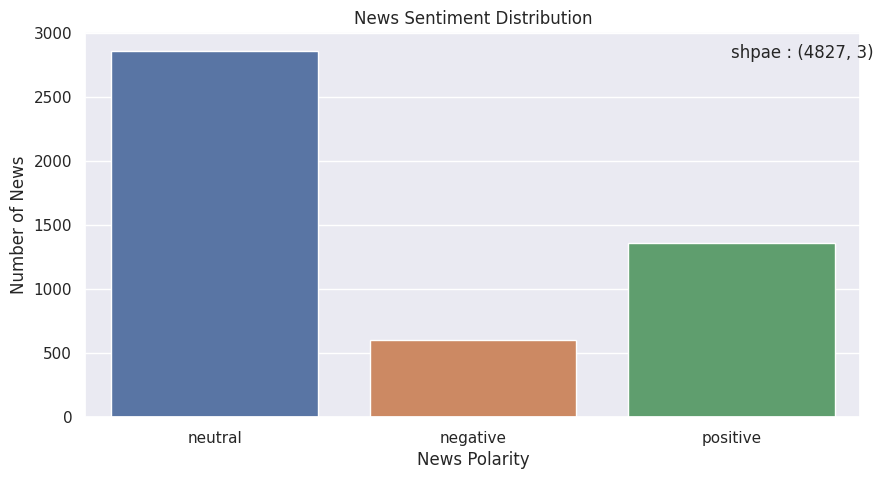

In [ ]:
# Configure the plot size
plt.figure(figsize = (10,5))
# Increase information on the figure
sns.set(font_scale=1)
sns.countplot(x='sentiment', data = financial_data)
plt.title('News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')
plt.text(2,2800,f'shpae : {financial_data.shape}')

- Checking Data Distribution

In [ ]:
def get_sentences_len(df):
    sentences_sequence_lengths = []
    print("Encoding in progress...")
    for sentence in tqdm(df.kor_sentence):
        encoded_sentence = tokenizer.encode(sentence,
                                         add_special_tokens = True)
        # record the length of the encoded review
        sentences_sequence_lengths.append(len(encoded_sentence))
    print("End of Task.")
    return sentences_sequence_lengths

def show_sentence_distribution(sequence_lengths, figsize = (15,8)):
    # Get the percentage of reviews with length > 512
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus)/len(sequence_lengths))*100
    print("Maximum Sequence Length is {}".format(max(sequence_lengths)))

    # Configure the plot size
    plt.figure(figsize = figsize)

    # Plot the result
    sns.distplot(sequence_lengths, kde = False, rug = False)
    plt.title('sentences Lengths Distribution')
    plt.xlabel('sentences Length')
    plt.ylabel('Number of sentences')

Encoding in progress...


100% 4827/4827 [00:00<00:00, 7125.70it/s]
/tmp/ipykernel_784/2432005828.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sequence_lengths, kde = False, rug = False)


End of Task.
Maximum Sequence Length is 112


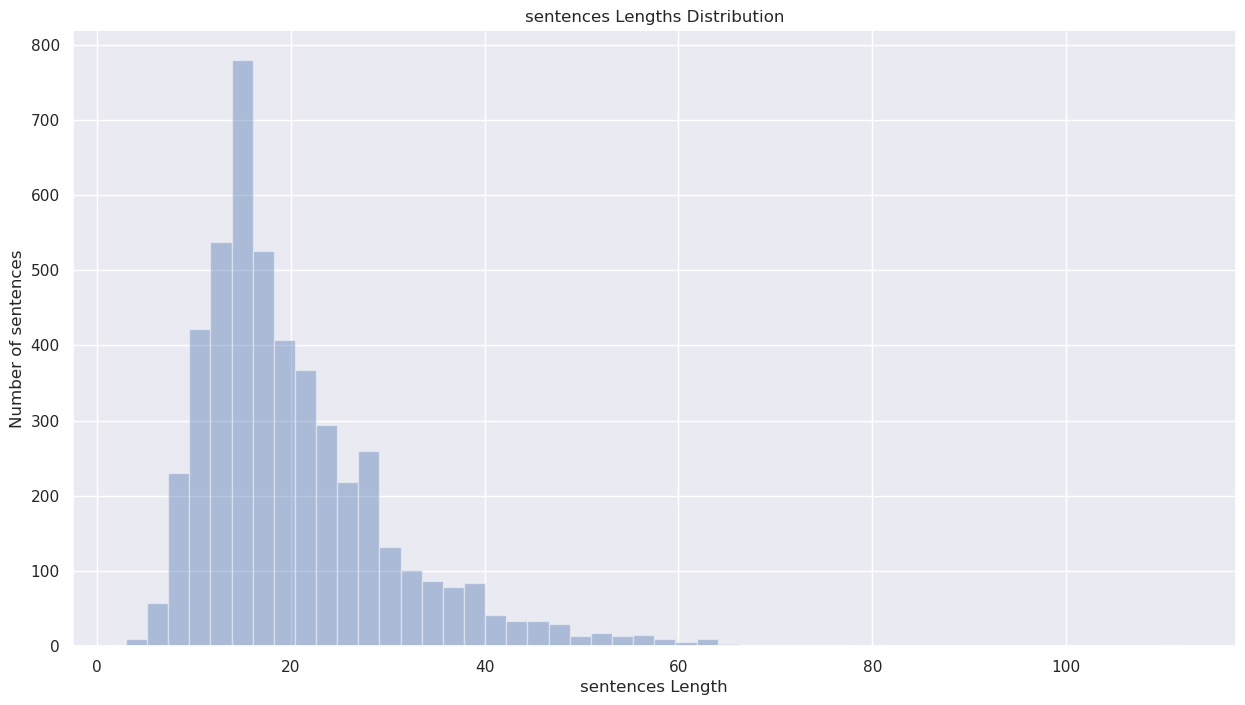

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("kwoncho/KoFinBERT",
                                                  do_lower_case=True)
sentences_sequence_lengths = get_sentences_len(financial_data)
show_sentence_distribution(sentences_sequence_lengths)
# 문장 최대 길이 : 112

### 4. Sentiment Analysis

- 모델 정의 및 데이터 분할

In [ ]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("kwoncho/KoFinBERT")
model = AutoModelForSequenceClassification.from_pretrained("kwoncho/KoFinBERT")
# Classifier
text_classifier = TextClassificationPipeline(tokenizer = tokenizer,
                                             model= model)
# feature, Target 데이터 분리
X_data = financial_data['kor_sentence']
y_data = financial_data['label']

- 감정분류 진행

In [ ]:
X_li = list(X_data)
with tqdm(total=len(X_li)) as pbar:
    sentiment_li = []
    for item in X_li:
        result = text_classifier([item])
        label = result[0]['label']
        sentiment = 1 if label == 'positive' else 0 if label == 'neutral' else 2
        sentiment_li.append(sentiment)
        pbar.update(1)
y_pred = sentiment_li

100% 4827/4827 [06:13<00:00, 12.91it/s]


- 감정분류 성능 평가

In [ ]:
# 정확도 계산
accuracy = accuracy_score(y_pred, y_data)
print("정확도:", accuracy)

# 정밀도 계산
precision = precision_score(y_pred, y_data, average='weighted')
print("정밀도:", precision)

# 재현율 계산
recall = recall_score(y_pred, y_data, average='weighted')
print("재현율:", recall)

# F1 스코어 계산
f1 = f1_score(y_pred, y_data, average='weighted')
print("F1 스코어:", f1)

# Cohen's Kappa score 계산
kappa = cohen_kappa_score(y_pred, y_data)
print("Cohen's Kappa score:", kappa)

정확도: 0.7768800497203232
정밀도: 0.8024512981840617
재현율: 0.7768800497203232
F1 스코어: 0.7838621759143496
Cohen's Kappa score: 0.5744555924481709


In [ ]:
financial_data = financial_data
financial_data['predict_label'] = y_pred
financial_data.head()

,label,kor_sentence,sentiment,predict_label
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...",neutral,0
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,neutral,0
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...",negative,2
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,positive,1
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...",positive,0


In [ ]:
metric_total = pd.DataFrame({'PLM':'KoFinBERT','Accuracy': [accuracy], 'Precision': [precision],
                            'Recall': [recall], 'F1_Score': [f1], 'kappa': [kappa]})
metric_total

,PLM,Accuracy,Precision,Recall,F1_Score,kappa
0,KoFinBERT,0.77688,0.802451,0.77688,0.783862,0.574456


- 뉴스 기사 감정 스코어 예측

In [ ]:
def sentiment_scoring(start_date, end_date, keyword,content_type):

    # Read the Month News Data
    for month in pd.date_range(start_date, end_date, freq = 'M'):
        file_path = f'/content/drive/MyDrive/산업 AI 캡스톤/DATA/Preprocessing_Data/{keyword}_Preprocessing_News_Data'
        file_name = f"news_preprocess_{month.strftime('%Y%m')}_{keyword}.csv"
        month_news_data = mountInstance.loadData(file_path = file_path, file_name_extension = file_name,
                                                 unicode='utf-8-sig', columnTF=False)

        month_news_data['title_content'] = month_news_data['title'] + month_news_data['summarize_content']

        # Train, Target 데이터 분리
        X_data = month_news_data[content_type]
        X_li = list(X_data)

        # Sentiment Score 계산
        with tqdm(total=len(X_li)) as pbar:
            sentiment_li = []
            for item in X_li:
                result = text_classifier([item])
                label = result[0]['label']
                sentiment = 1 if label == 'positive' else 0 if label == 'neutral' else 2
                sentiment_li.append(sentiment)
                pbar.update(1)
        # DataFrame 생성 및 저장
        month_news_data = month_news_data[['pubdate','pub_date_time',content_type]]
        month_news_data['tmp_score'] = sentiment_li

        # sentiment_score :부정 = -1, 중립 = 0, 긍정 = 1
        month_news_data['sentiment_score'] = month_news_data['tmp_score'].replace({2:-1})
        month_news_data = month_news_data.drop('tmp_score',axis=1)

        # 장 마감시간인 15시30분을 넘으면 다음 날짜 데이터로 변환
        month_news_data['pub_time'] = month_news_data['pub_date_time'].astype(str).str[8:12].astype(int)
        month_news_data['Date'] = np.where(month_news_data['pub_time'] > 1530,
                                            month_news_data['pubdate'] + 1,
                                            month_news_data['pubdate'])
        month_news_data.drop('pub_time',inplace=True,axis=1)

        # date 기준으로 그룹화하고 'sentiment_score'의 평균을 계산
        daily_sentiments = month_news_data.groupby('Date')['sentiment_score'].mean().reset_index()
        daily_sentiment_df = daily_sentiment_df.append(daily_sentiments)

    # Save File path
    file_path = f'/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/'
    daily_sentiment_df.to_csv(file_path + f'Sentiment_Score_{content_type}_{keyword}_KOFINBERT.csv',index=False)

    return daily_sentiment_df

- Kospi Sentiment Analysis_원본 요약 본문

In [ ]:
start_date = '2023-01'
end_date = '2023-07'
keyword = "Kospi"
content_type = 'summarize_content'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kosdaq Sentiment Analysis_원본 요약 본문

In [ ]:
start_date = '2022-11'
end_date = '2023-01'
keyword = "Kosdaq"
content_type = 'summarize_content'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kospi Sentiment Analysis_전처리 요약 본문

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kospi"
content_type = 'preprocess_context'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kosdaq Sentiment Analysis_전처리 요약 본문

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kosdaq"
content_type = 'preprocess_context'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kospi Sentiment Analysis_제목

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kospi"
content_type = 'title'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kosdaq Sentiment Analysis_제목

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kosdaq"
content_type = 'title'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kospi Sentiment Analysis_요약 본문 + 제목 감정

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kospi"
content_type = 'title_content'
sentiment_scoring(start_date, end_date, keyword,content_type)

- Kosdaq Sentiment Analysis_요약 본문 + 제목 감정

In [ ]:
start_date = '2021-01'
end_date = '2023-07'
keyword = "Kosdaq"
content_type = 'title_content'
sentiment_scoring(start_date, end_date, keyword,content_type)

### 5. Data Preprocessing

- Data Load

In [45]:
# Kospi
Sentiment_Score_summarize_content_Kospi_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_summarize_content_Kospi_KOFINBERT.csv')
Sentiment_Score_preprocess_content_Kospi_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_preprocess_context_Kospi_KOFINBERT.csv')
Sentiment_Score_title_Kospi_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_title_Kospi_KOFINBERT.csv')
Sentiment_Score_title_content_Kospi_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_title_content_Kospi_KOFINBERT.csv')
# Kosdaq
Sentiment_Score_summarize_content_Kosdaq_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_summarize_content_Kospi_KOFINBERT.csv')
Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_preprocess_context_Kosdaq_KOFINBERT.csv')
Sentiment_Score_title_Kosdaq_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_title_Kosdaq_KOFINBERT.csv')
Sentiment_Score_title_content_Kosdaq_KOFINBERT = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Sentiment_Score_Data/Sentiment_Score_title_content_Kosdaq_KOFINBERT.csv')

- Normalize with Z-Score

In [46]:
def z_norm(df):
    # 정규화 진행할 칼럼 추출
    score = df['sentiment_score']
    # Z-normalize : 각 데이터의 평균 / 표준 편차
    z_norm_score = zscore(score)
    # Z-normalize된 값을 데이터 프레임에 할당
    df['z_norm_sentiment_score'] = z_norm_score
    return df

In [47]:
Sentiment_Score_summarize_content_Kospi_KOFINBERT = z_norm(Sentiment_Score_summarize_content_Kospi_KOFINBERT)
Sentiment_Score_preprocess_content_Kospi_KOFINBERT = z_norm(Sentiment_Score_preprocess_content_Kospi_KOFINBERT)
Sentiment_Score_title_Kospi_KOFINBERT = z_norm(Sentiment_Score_title_Kospi_KOFINBERT)
Sentiment_Score_title_content_Kospi_KOFINBERT = z_norm(Sentiment_Score_title_content_Kospi_KOFINBERT)

Sentiment_Score_summarize_content_Kosdaq_KOFINBERT = z_norm(Sentiment_Score_summarize_content_Kosdaq_KOFINBERT)
Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT = z_norm(Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT)
Sentiment_Score_title_Kosdaq_KOFINBERT = z_norm(Sentiment_Score_title_Kosdaq_KOFINBERT)
Sentiment_Score_title_content_Kosdaq_KOFINBERT = z_norm(Sentiment_Score_title_content_Kosdaq_KOFINBERT)

### 6. Sentiment Graphing

- Kospi

Text(0.5, 1.0, 'Sentiment_Score_summarize_content_Kospi_KOFINBERT')

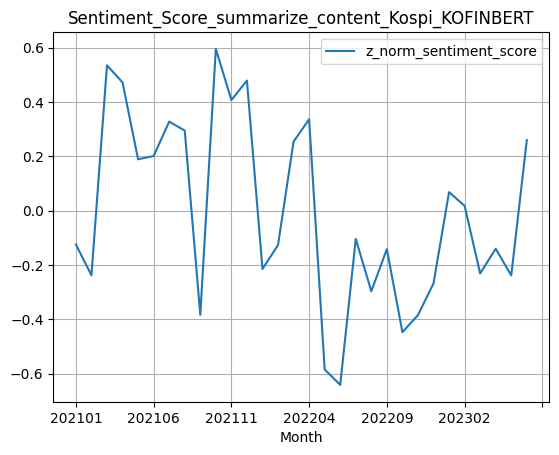

In [41]:
df = Sentiment_Score_summarize_content_Kospi_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot()
plt.grid(True)
plt.title('Sentiment_Score_summarize_content_Kospi_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_summarize_content_Kospi_KOFINBERT')

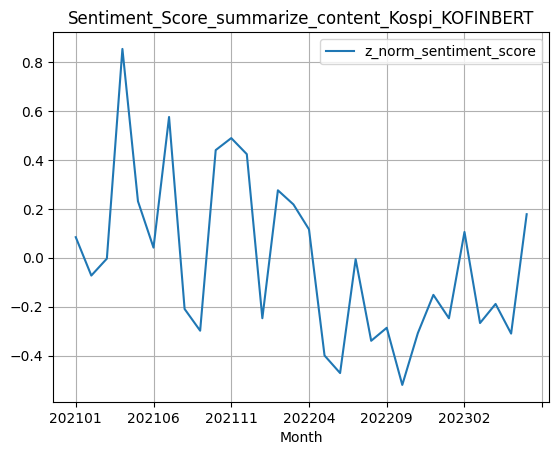

In [48]:
df = Sentiment_Score_preprocess_content_Kospi_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot()
plt.grid(True)
plt.title('Sentiment_Score_summarize_content_Kospi_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_title_Kospi_KOFINBERT')

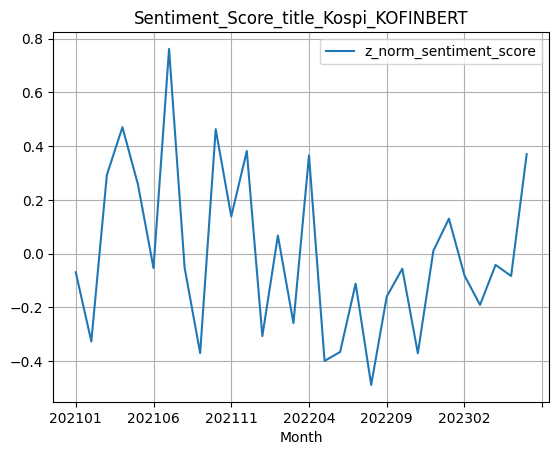

In [49]:
df = Sentiment_Score_title_Kospi_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot()
plt.grid(True)
plt.title('Sentiment_Score_title_Kospi_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_title_content_Kospi_KOFINBERT')

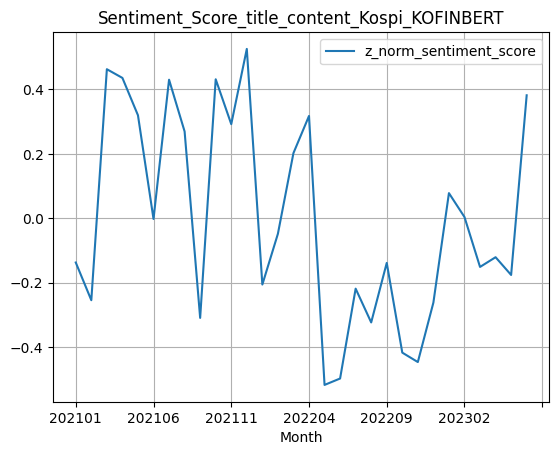

In [50]:
df = Sentiment_Score_title_content_Kospi_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot()
plt.grid(True)
plt.title('Sentiment_Score_title_content_Kospi_KOFINBERT')

- Kosdaq

Text(0.5, 1.0, 'Sentiment_Score_summarize_content_Kosdaq_KOFINBERT')

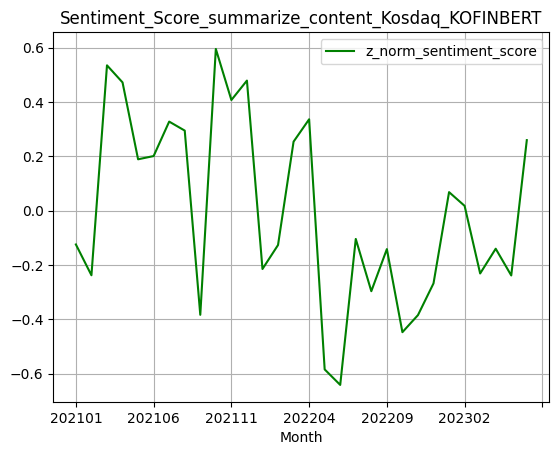

In [51]:
df = Sentiment_Score_summarize_content_Kosdaq_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot(color = 'green')
plt.grid(True)
plt.title('Sentiment_Score_summarize_content_Kosdaq_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT')

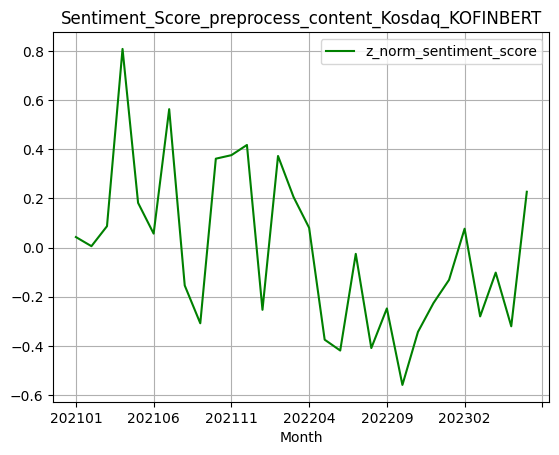

In [52]:
df = Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot(color = 'green')
plt.grid(True)
plt.title('Sentiment_Score_preprocess_content_Kosdaq_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_title_Kosdaq_KOFINBERT')

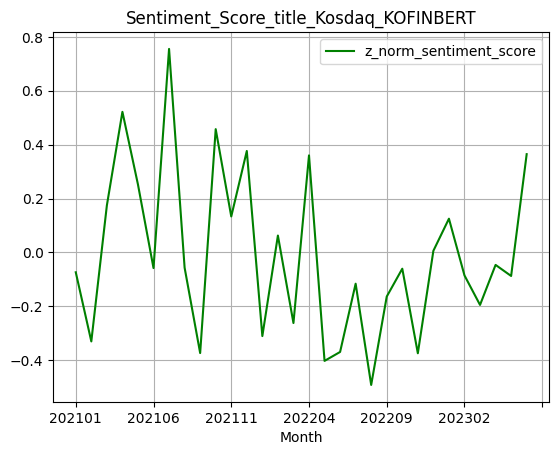

In [53]:
df = Sentiment_Score_title_Kosdaq_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot(color = 'green')
plt.grid(True)
plt.title('Sentiment_Score_title_Kosdaq_KOFINBERT')

Text(0.5, 1.0, 'Sentiment_Score_title_content_Kosdaq_KOFINBERT')

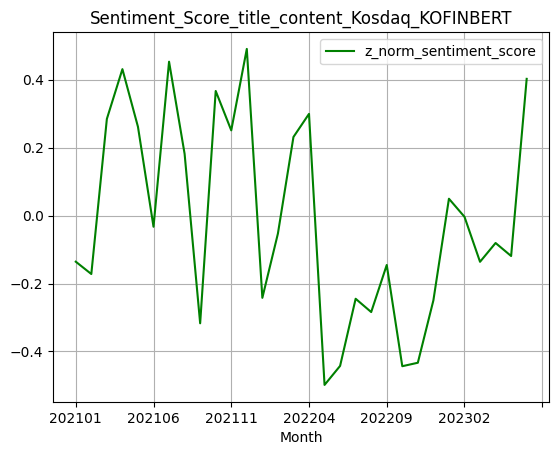

In [54]:
df = Sentiment_Score_title_content_Kosdaq_KOFINBERT

df['Month'] = df['Date'].astype(str).str[:6]
df.drop('Date',inplace=True,axis=1)
df.drop('sentiment_score',inplace=True,axis=1)
month_score = df.groupby('Month').mean()
month_score.plot(color = 'green')
plt.grid(True)
plt.title('Sentiment_Score_title_content_Kosdaq_KOFINBERT')